In [1]:
import pandas as pd
import json
import requests
import datetime
from config import postgres_url_user_pass
from config import postgres_server

In [2]:
#URL found from viewing web inspector in web browser to find the current list of issues
url = "https://seeclickfix.com/api/v2/issues?min_lat=39.03211937423035&min_lng=-95.71889877319336&max_lat=39.052118348329074&max_lng=-95.6312656402588&status=open%2Cacknowledged%2Cclosed&fields%5Bissue%5D=id%2Csummary%2Cdescription%2Cstatus%2Clat%2Clng%2Caddress%2Cmedia%2Ccreated_at%2Cacknowledged_at%2Cclosed_at&page=1"

In [3]:
#grab an initial response to grab the total number of pages
response = requests.get(url).json()
total_pages = response['metadata']['pagination']['pages']

In [4]:
#define a function to get urls from the initial URL 
def get_issues(url):
    #create a temp list for all issues to return
    all_issues = []
    for i in range(1,total_pages +1):
        print(f"getting page {i} of {total_pages}")
        response = requests.get(url).json()
        next_page_url = response['metadata']['pagination']['next_page_url']
        page_issues = response['issues']
        #add current list of issues to the existing list of issues
        all_issues.extend(page_issues)
        #set URL to next page to get the next set of issues
        url = next_page_url
    #return the list of all issues
    return all_issues

In [5]:
# call function to get all issues
all_issues = get_issues(url)

getting page 1 of 11
getting page 2 of 11
getting page 3 of 11
getting page 4 of 11
getting page 5 of 11
getting page 6 of 11
getting page 7 of 11
getting page 8 of 11
getting page 9 of 11
getting page 10 of 11
getting page 11 of 11


In [6]:
#create dataframe from issue list
issues_df = pd.DataFrame(all_issues)
#set index to the issues id
issues_df = issues_df.set_index('id')

In [7]:
def clean_summary(df):
    #convert dates
    df['created_at'] = pd.to_datetime(
        df['created_at'], format="%Y/%m/%d", utc=True)
    df['acknowledged_at'] = pd.to_datetime(
        df['acknowledged_at'], format="%Y/%m/%d", utc=True)
    df['closed_at'] = pd.to_datetime(
        df['closed_at'], format="%Y/%m/%d", utc=True)
    # calculate time to acknowledge
    df['time to acknowledge'] = df['acknowledged_at'] - df['created_at']
    df['time to close'] = df['closed_at'] - df['created_at']
    
    #return daframe and replace known errant values
    return df.replace({"Curb and Gutter": "Curb and Gutter Repair",
                       "Junk Yard?": "Property Maintenance & Code Violations",
                       "skatepark light": "safety lighting",
                       "Dead animal on sidewalk ": "Police Animal Control",
                       "Loud pedestrian crossing ": "Street Sign Repair",
                       "Pothole": "Street Repair"})


In [8]:
# call function to clean the summary column
issues_df = clean_summary(issues_df)

In [9]:
status_list = issues_df['status'].value_counts()

In [10]:
summary_list = issues_df['summary'].value_counts()
summary_list

Property Maintenance & Code Violations    64
Curb and Gutter Repair                    44
Street Repair                             21
Sidewalk and Ramp                         15
Alley                                     15
Police General Issue                      10
Trees and Tree Limbs                       8
General Feedback or Questions              5
Other                                      4
Traffic Signal Repair                      4
safety lighting                            2
Hole in Buffalo                            1
Question?                                  1
Downtown Parking General Question          1
Snow or Ice Hazard                         1
Utility Work Damage                        1
Street Light Out                           1
Loose trash in ally at this residence.     1
dangerous parking                          1
Street Sign Repair                         1
Loud pedestrian crossing                   1
Name: summary, dtype: int64

In [11]:
summary_df = pd.DataFrame(issues_df.groupby('summary')['status'].count())

<AxesSubplot:xlabel='summary'>

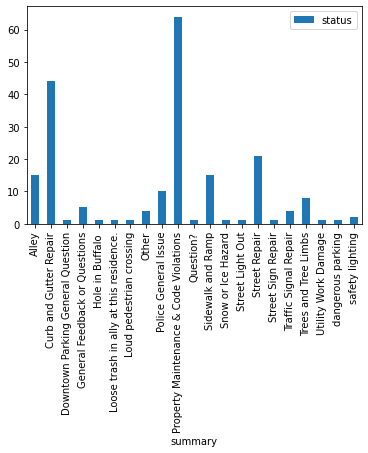

In [12]:
summary_df.plot(kind="bar")

<AxesSubplot:xlabel='status'>

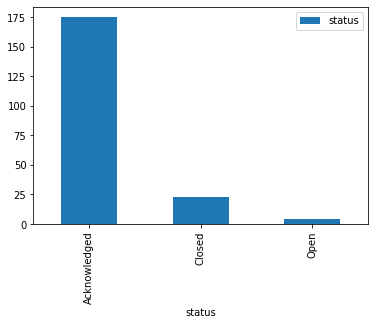

In [13]:
status = pd.DataFrame(issues_df.groupby('status')['status'].count())
status.plot(kind="bar")

In [14]:
issues_df['time to acknowledge']

id
11897808   0 days 00:00:25
11897781   0 days 00:00:17
11896851   0 days 00:00:09
11896384   0 days 00:00:06
11894638   0 days 00:00:09
                 ...      
3400442    6 days 04:11:23
3374188    0 days 00:00:27
3321776    0 days 00:10:23
3225285    0 days 00:00:38
3134538    0 days 00:00:16
Name: time to acknowledge, Length: 202, dtype: timedelta64[ns]

In [15]:
issues_df.groupby('time to acknowledge')['time to acknowledge'].count()

time to acknowledge
0 days 00:00:02       5
0 days 00:00:03      11
0 days 00:00:04      18
0 days 00:00:05      21
0 days 00:00:06       8
0 days 00:00:07      12
0 days 00:00:08       9
0 days 00:00:09       5
0 days 00:00:10       2
0 days 00:00:11       7
0 days 00:00:12       3
0 days 00:00:13       4
0 days 00:00:14       7
0 days 00:00:15       3
0 days 00:00:16       6
0 days 00:00:17       5
0 days 00:00:18       2
0 days 00:00:19       5
0 days 00:00:20       3
0 days 00:00:21       1
0 days 00:00:22       4
0 days 00:00:23       5
0 days 00:00:24       6
0 days 00:00:25       5
0 days 00:00:26       3
0 days 00:00:27       2
0 days 00:00:28       1
0 days 00:00:29       2
0 days 00:00:32       3
0 days 00:00:33       3
0 days 00:00:34       1
0 days 00:00:36       3
0 days 00:00:37       2
0 days 00:00:38       1
0 days 00:00:39       2
0 days 00:00:40       2
0 days 00:00:42       1
0 days 00:00:45       1
0 days 00:00:48       1
0 days 00:01:20       1
0 days 00:01:26     

In [32]:
#save to CSV, in case you want to
issues_df.to_csv("all_issues.csv")

In [ ]:
#CREATE TABLE public.test
#(
#    test integer
#);


In [31]:
#using code to create SQL code
print("create table issues_import_test (")
for col in issues_df.columns:
    print(f'"{col}" text,')
print(");")

create table issues_import_test (
"status" text,
"summary" text,
"description" text,
"lat" text,
"lng" text,
"address" text,
"created_at" text,
"acknowledged_at" text,
"closed_at" text,
"url" text,
"media" text,
"time to acknowledge" text,
"time to close" text,
);


# Let's rock this out to the DB and go from there

In [36]:
from sqlalchemy import create_engine
import psycopg2
#postgres_url_user_pass = "user:pass"
#postgres_server = "127.0.0.1"
engine = create_engine(
    f'postgresql+psycopg2://{postgres_url_user_pass}@{postgres_server}/seeClickFix', echo=False)

In [45]:
#remove problem desc column and media column
issues_df= issues_df[['status', 'summary', 'lat', 'lng', 'address',
       'created_at', 'acknowledged_at', 'closed_at', 'url',
       'time to acknowledge', 'time to close']]


In [46]:
issues_df.to_sql('seeClickFixExport',engine,if_exists="replace")

In [52]:
cleaned_df =pd.read_sql('select * from all_issues', engine)

In [54]:
cleaned_df.dtypes

id                               int64
summary                         object
status                          object
created_at         datetime64[ns, UTC]
acknowledged_at    datetime64[ns, UTC]
closed_at          datetime64[ns, UTC]
time_to_ack            timedelta64[ns]
time_to_close          timedelta64[ns]
time_to_resolve        timedelta64[ns]
dtype: object

In [72]:
#using code to create SQL code
print("create table issues_import_test (")
for col in issues_df.columns:
    print(f'"{col}" {findType(issues_df,col)},')
print(");")

create table issues_import_test (
"status" text,
"summary" text,
"lat" float,
"lng" float,
"address" text,
"created_at" text,
"acknowledged_at" text,
"closed_at" text,
"url" text,
"time to acknowledge" text,
"time to close" text,
);


In [71]:
def findType(df, column):
    if (df.dtypes[column]=='float64' ):
        return 'float'
    #issues_df.dtypes['lat'] == 'float64'
    return "text"

In [63]:
for d in issues_df['status'].dtypes:
    
    print(d)

TypeError: 'numpy.dtype' object is not iterable

In [70]:
issues_df.dtypes['lat'] == 'float64'

True